In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')

In [3]:
transactions = transactions.merge(products, on='ProductID', how='left')

In [7]:
customer_profiles = transactions.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'TransactionID': 'count',  # Number of transactions
    'Price_x': 'mean'  # Average price per transaction
}).reset_index()
customer_profiles.columns = ['CustomerID', 'TotalSpending', 'TransactionCount', 'AverageTransactionValue']

In [9]:
customer_data = customers.merge(customer_profiles, on='CustomerID', how='left').fillna(0)

In [11]:
features = customer_data[['TotalSpending', 'TransactionCount', 'AverageTransactionValue']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [13]:
db_scores = []
silhouette_scores = []
clusters_range = range(2, 11)

for k in clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    labels = kmeans.labels_
    db_index = davies_bouldin_score(scaled_features, labels)
    sil_score = silhouette_score(scaled_features, labels)
    db_scores.append(db_index)
    silhouette_scores.append(sil_score)

# Optimal Clusters
optimal_k = clusters_range[np.argmin(db_scores)]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_features)
customer_data['Cluster'] = kmeans.labels_

# Step 4: Evaluate Clustering
print(f"Optimal number of clusters: {optimal_k}")
print(f"Davies-Bouldin Index for optimal clusters: {min(db_scores):.2f}")
print(f"Silhouette Score for optimal clusters: {max(silhouette_scores):.2f}")

C:\Users\Haard\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Haard\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Haard\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Haard\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

Optimal number of clusters: 10
Davies-Bouldin Index for optimal clusters: 0.93
Silhouette Score for optimal clusters: 0.36


C:\Users\Haard\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [23]:
# Create a DataFrame to store DB Index values and cluster numbers
db_index_data = pd.DataFrame({
    'Number of Clusters': list(clusters_range),
    'DB Index': db_scores
})

# Add a column to indicate the optimal cluster (min DB Index)
db_index_data['Optimal'] = db_index_data['DB Index'] == db_index_data['DB Index'].min()

# Print the table
print("DB Index for Different Cluster Numbers:")
print(db_index_data)




DB Index for Different Cluster Numbers:
   Number of Clusters  DB Index  Optimal
0                   2  1.044924    False
1                   3  1.007184    False
2                   4  0.999873    False
3                   5  1.000248    False
4                   6  1.021944    False
5                   7  0.975880    False
6                   8  0.950217    False
7                   9  1.030702    False
8                  10  0.934729     True


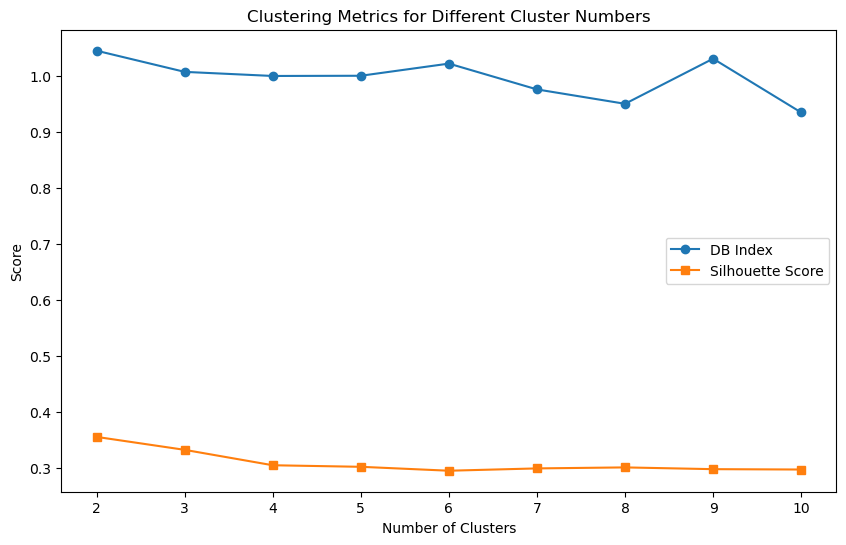

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(clusters_range, db_scores, marker='o', label='DB Index')
plt.plot(clusters_range, silhouette_scores, marker='s', label='Silhouette Score')
plt.title('Clustering Metrics for Different Cluster Numbers')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()

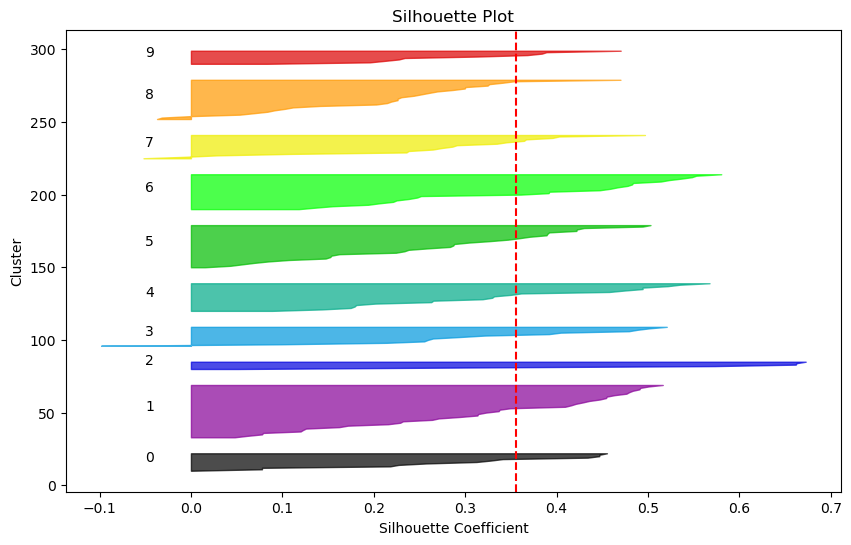

In [17]:
plt.figure(figsize=(10, 6))
sample_silhouette_values = silhouette_samples(scaled_features, customer_data['Cluster'])
y_lower = 10
for i in range(optimal_k):
    ith_cluster_silhouette_values = sample_silhouette_values[customer_data['Cluster'] == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / optimal_k)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
plt.title('Silhouette Plot')
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster')
plt.axvline(x=max(silhouette_scores), color="red", linestyle="--")
plt.show()

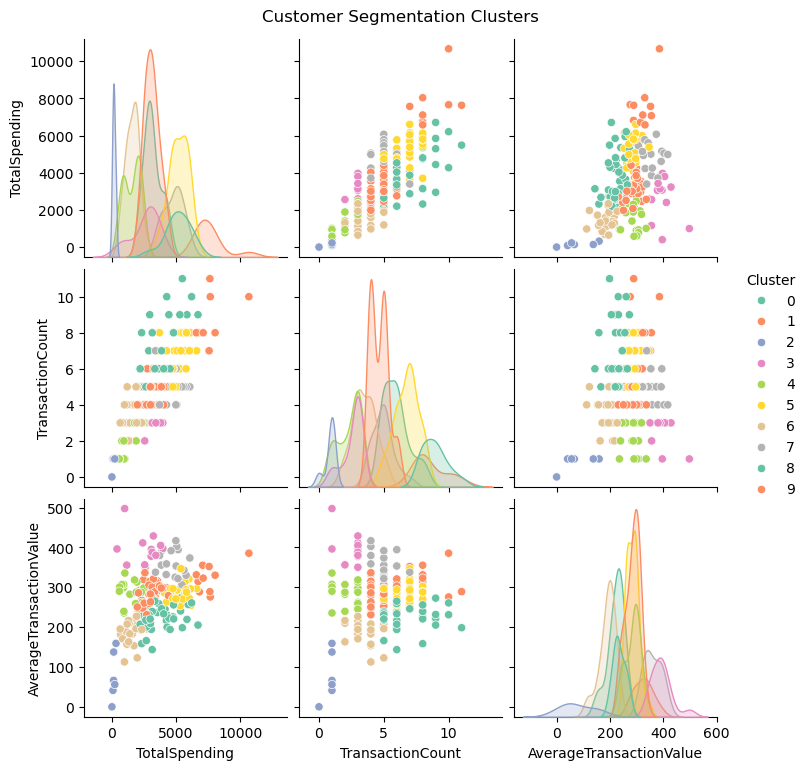

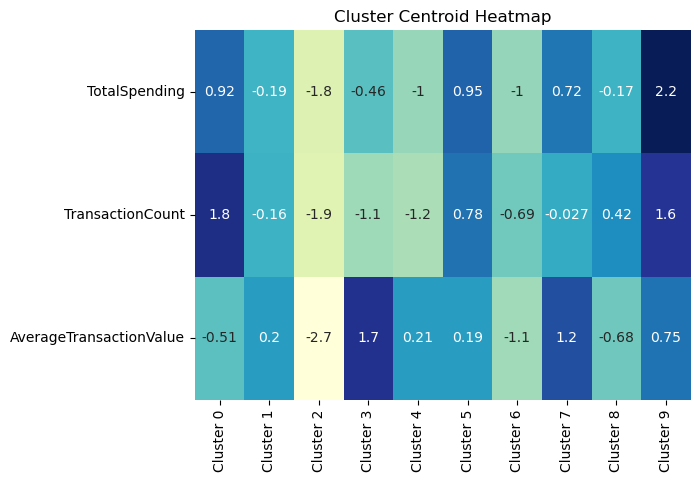

CustomerClusters.csv generated successfully.


In [19]:
sns.pairplot(customer_data, vars=['TotalSpending', 'TransactionCount', 'AverageTransactionValue'], hue='Cluster', palette='Set2', diag_kind='kde')
plt.suptitle('Customer Segmentation Clusters', y=1.02)
plt.show()

# Centroid Heatmap
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=['TotalSpending', 'TransactionCount', 'AverageTransactionValue'])
sns.heatmap(centroids.T, annot=True, cmap="YlGnBu", xticklabels=[f"Cluster {i}" for i in range(optimal_k)], cbar=False)
plt.title('Cluster Centroid Heatmap')
plt.show()

# Save Results
customer_data[['CustomerID', 'Cluster']].to_csv('CustomerClusters.csv', index=False)
print("CustomerClusters.csv generated successfully.")